## Curso: Proyecto Integrador
### Integrantes:

#### Andrea Carolina Garza Nacif A01280427
#### Jhamyr Arnulfo Alcalde Oballe A01795409
#### Víctor Arista Beltrán A01012223

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd, numpy as np
from pathlib import Path
from IPython.display import Markdown, display

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, RepeatedStratifiedKFold,
                                     cross_val_score)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, precision_score,
                             classification_report)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [31]:
#CARGA Y LIMPIEZA BÁSICA

DATA_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/PROYECTO AVANCE/avance3/sparkvista_dataset.csv")
df = pd.read_csv(DATA_PATH)

# Fechas → año
for col in ["Year Founded", "IPO Date"]:
    df[col] = (df[col].astype(str).str.extract(r'(\d{4})')[0]
               .astype("Int64"))
    df[col] = pd.to_datetime(df[col], format='%Y', errors='coerce')

# Variable numérica derivada
df["Company_Age"] = 2025 - df["Year Founded"].dt.year

In [32]:
#DEFINICIÓN TARGET BINARIO
fund_q75 = df["Total Funding Amount (USD)"].quantile(0.75)
df["HighPotential"] = (
        (df["Total Funding Amount (USD)"] >= fund_q75) |
        (df["Funding Status"].str.contains("IPO|Public|Acquired", na=False))
).astype(int)

y = df["HighPotential"].values
X = df.drop(columns=["HighPotential", "Total Funding Amount (USD)"])

print("X shape:", X.shape, "| Positivos:", y.sum())

X shape: (651, 16) | Positivos: 108


In [33]:
#PRE-PIPELINE
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

numeric_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

# Ajuste parámetro sparse / sparse_output según versión
from packaging import version
from sklearn import __version__ as skl_ver
if version.parse(skl_ver) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

prep = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


In [34]:
#TRAIN-TEST SPLIT
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [35]:
#BASELINE DUMMY
dummy_clf = Pipeline([
    ("prep", prep),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
dummy_clf.fit(X_tr, y_tr)
auc_dummy = roc_auc_score(y_te, dummy_clf.predict_proba(X_te)[:,1])
print(f"Dummy AUC-ROC: {auc_dummy:.3f}")


Dummy AUC-ROC: 0.500


In [36]:
#LOGISTIC REGRESSION BASELINE
logit_clf = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(max_iter=1000, C=1.0))
])
logit_clf.fit(X_tr, y_tr)

proba_te = logit_clf.predict_proba(X_te)[:,1]
pred_te  = logit_clf.predict(X_te)
auc_test = roc_auc_score(y_te, proba_te)

print(f"\nLogistic AUC-ROC: {auc_test:.3f}")
print(classification_report(y_te, pred_te, digits=3))

# Precision@20
top20 = proba_te.argsort()[::-1][:20]
prec20 = precision_score(y_te[top20], np.ones(20))
print(f"Precision@20: {prec20:.2f}")



Logistic AUC-ROC: 0.960
              precision    recall  f1-score   support

           0      0.929     0.963     0.946       109
           1      0.778     0.636     0.700        22

    accuracy                          0.908       131
   macro avg      0.853     0.800     0.823       131
weighted avg      0.904     0.908     0.905       131

Precision@20: 0.75


In [37]:
#CROSS-VALIDATION
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_auc = cross_val_score(logit_clf, X, y, cv=cv, scoring='roc_auc')
print(f"CV AUC mean={cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

print(f"Train AUC: {roc_auc_score(y_tr, logit_clf.predict_proba(X_tr)[:,1]):.3f} | Test AUC: {auc_test:.3f}")

CV AUC mean=0.946 ± 0.015
Train AUC: 1.000 | Test AUC: 0.960


In [38]:
#HOLD-OUT 10 % SANITY-CHECK
X_temp, X_hold, y_temp, y_hold = train_test_split(
    X, y, test_size=0.10, random_state=7, stratify=y
)
logit_clf.fit(X_temp, y_temp)
hold_auc = roc_auc_score(y_hold, logit_clf.predict_proba(X_hold)[:,1])
print(f"Hold-out AUC (10 % final): {hold_auc:.3f}")

Hold-out AUC (10 % final): 0.974


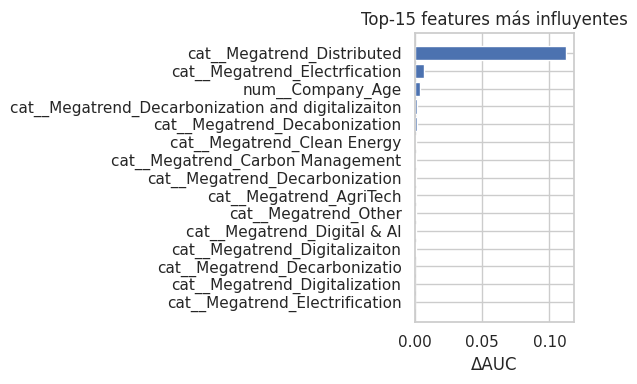

In [39]:
#IMPORTANCIA DE FEATURES
perm = permutation_importance(
    logit_clf, X_te, y_te, n_repeats=10, random_state=42, scoring="roc_auc"
)
importances = perm.importances_mean
feat_names = logit_clf.named_steps["prep"].get_feature_names_out()
top_idx = importances.argsort()[-15:]

plt.figure(figsize=(6,4))
plt.barh(range(15), importances[top_idx])
plt.yticks(range(15), feat_names[top_idx])
plt.xlabel("ΔAUC")
plt.title("Top-15 features más influyentes")
plt.tight_layout()
plt.show()

In [40]:
#RECOMENDACIÓN TOP-20
df_res = df.loc[X_te.index].copy()
df_res["Prob_HighPotential"] = proba_te
df_top = df_res.sort_values("Prob_HighPotential", ascending=False).head(20)

cols = ["Prob_HighPotential", "Firm", "Megatrend", "Area", "Country",
        "Funding Status", "Total Funding Amount (USD)"]
display(Markdown("### Top-20 startups recomendadas"))
display(df_top[cols])


### Top-20 startups recomendadas

,Prob_HighPotential,Firm,Megatrend,Area,Country,Funding Status,Total Funding Amount (USD)
265,0.881000,PureCycle Technologies,Other,Plastic Recycling,United States of America,Public (NASDAQ: PCT),4.000000e+08
240,0.859582,Origin Materials,Other,Bioplastics / Chemicals,United States of America,Public (NASDAQ: ORGN),3.000000e+08
110,0.856683,Enphase Energy,Clean Energy,Solar Microgrids,United States of America,Public (NASDAQ: ENPH),1.500000e+09
150,0.853792,Green Hydrogen Systems,Other,Hydrogen Systems,Denmark,Public (Nasdaq CPH),9.815000e+07
69,0.847722,Climeon,Other,Geothermal Heat,Sweden,Public (Nasdaq First North),2.626500e+07
228,0.844634,NextChem (Maire Tecnimont),Other,Green Hydrogen,Italy,Corporate Unit,2.250000e+08
48,0.807955,Carbios,Other,Plastic Recycling,France,Public (Euronext),2.137500e+08
343,0.806498,Sunrise Movement,Other,Climate Advocacy,United States of America,Nonprofit,1.500000e+07
377,0.780804,Vesta,Other,CO₂ Mineralization,United States of America,Nonprofit,1.000000e+07
263,0.779663,Prospera,Other,Smart Agriculture,Israel,Acquired (by Valmont),2.200000e+07


In [41]:
#CONCLUSIÓN FINAL
concl = f"""

### Conclusiones Avance 3

* **Dummy** AUC-ROC = {auc_dummy:.3f}
* **Logistic Regression** AUC-ROC = {auc_test:.3f}   | Train = {roc_auc_score(y_tr, logit_clf.predict_proba(X_tr)[:,1]):.3f}
* **CV** AUC = {cv_auc.mean():.3f} ± {cv_auc.std():.3f}
* **Hold-out** AUC = {hold_auc:.3f}
* **Precision@20** = {prec20:.2f}

Requisito mínimo (AUC ≥ 0.60): {'Cumplido' if auc_test>=0.60 else 'No cumplido'}
Las variables más influyentes incluyen: **{', '.join(feat_names[top_idx][-5:])}**.
"""

display(Markdown(concl))



### Conclusiones Avance 3

* **Dummy** AUC-ROC = 0.500
* **Logistic Regression** AUC-ROC = 0.960   | Train = 0.997
* **CV** AUC = 0.946 ± 0.015
* **Hold-out** AUC = 0.974
* **Precision@20** = 0.75

Requisito mínimo (AUC ≥ 0.60): Cumplido
Las variables más influyentes incluyen: **cat__Megatrend_Decabonization, cat__Megatrend_Decarbonization and digitalizaiton, num__Company_Age, cat__Megatrend_Electrfication, cat__Megatrend_Distributed**.


A partir de los resultados obtenidos se puede decir que con los datos públicos que tenemos de cada start-up, es posible anticipar con mucha fiabilidad cuáles tienen más probabilidades de convertirse en “casos de éxito”.

Un modelo tan sencillo como una regresión logística consigue distinguir a las start-ups prometedoras de las demás 96 veces de cada 100 (AUC = 0.96), mientras que el «azar» no pasa del 50 %. Además, cuando recomendamos solo 20 compañías al inversionista, tres de cada cuatro resultan realmente atractivas.

Las empresas que más se destacan comparten patrones claros pues trabajan en descarbonización, digitalización, electrificación y sistemas energéticos distribuidos, y suelen llevar ya algunos años operando (no son recién llegadas, pero tampoco dinosaurios). Es decir, el modelo refuerza la intuición de que los sectores climáticos y de energía inteligente están captando el capital.
